# Visualizations
> The `vis` module of `pybx` can be used to visualize these "stacks"
of `MultiBx` objects, raw `ndarray`/`list`/`json` records, 
target annotations and model logits.

![](../data/box-1.png)


In [ ]:
#| default_exp vis

In [ ]:
#| export
import inspect
from collections import defaultdict

import numpy as np
from fastcore.basics import store_attr
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt

from pybx.basics import *
from pybx.anchor import bx
from pybx.ops import voc_keys
from pybx.sample import get_example, get_given_array

### Loading from disk
Load a sample image from the data directory `../data/image.jpg` and resize to `(200, 200)`. Original image size is `(256, 256)`.

In [ ]:
image_sz=(200, 200)

im, ann, lgt, clr = get_example(image_sz=image_sz, pth="../data", img_fn="image.jpg")

`im` is the image of a clock and a frame, 
`ann` are the annotations for the image in json format, 
`lgt` are logits (activations from a layer) which can be displayed on top of the image, 
`clr` is a dict representing the colors to use for the different annotation keys.

In [ ]:
ann, lgt, clr

([{'x_min': 102, 'y_min': 49, 'x_max': 176, 'y_max': 141, 'label': 'clock'},
  {'x_min': 10, 'y_min': 123, 'x_max': 70, 'y_max': 166, 'label': 'frame'}],
 None,
 {'frame': 'blue', 'clock': 'green'})

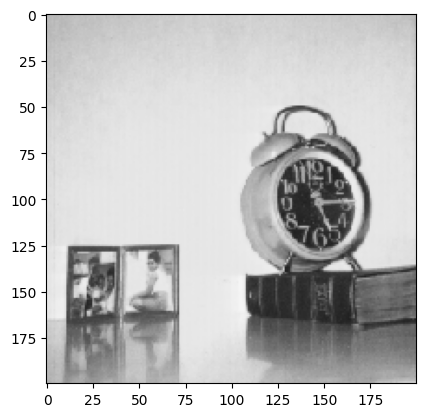

In [ ]:
_ = plt.imshow(im)

Store the annotations as a `MultiBx` object.

In [ ]:
get_bx(ann)

MultiBx(coords=[[102, 49, 176, 141], [10, 123, 70, 166]], label=['clock', 'frame'])

In [ ]:
# | export
def draw_outline(obj, linewidth: int):
    """Make outlines around to object edges for visibility in light backgrounds
    :param obj: plt objects like text or rectangle
    :param linewidth: width of the stroke
    :return: plt object
    """
    obj.set_path_effects(
        [
            patheffects.Stroke(linewidth=linewidth, foreground="black"),
            patheffects.Normal(),
        ]
    )


def get_color(color, label=None, default_color="white"):
    """Get colors from color dict for a given label. If label=None, return `default_color`.
    :param color: dict of key, value pairs where key is label, value is color
    :param label: the label for which color is needed
    :param default_color:
    :return: str that contains color
    """
    if isinstance(color, str):
        return color
    colors_d = defaultdict(lambda: default_color)
    colors_d.update(color)
    return colors_d[label]


def get_extents(shape):
    """Get extent parameter of the image."""
    assert (
        len(shape) == 3
    ), f"{inspect.stack()[0][3]} of {__name__}: Expected w, h, c = shape, got {shape} with len {len(shape)}"
    w, h, _ = shape
    extent = 0, w, h, 0
    return extent


def draw_text(ax, xy: tuple, label: str, size=12, color="white", xo=0, yo=0):
    """Write text around boxes.
    :param ax: axis object
    :param xy: relative ax coordinates x, y to draw the text
    :param label: label for box
    :param size: font size
    :param yo: y offset for placement of text
    :param xo: x offset for placement of text
    :param color: text color
    :return: ax object
    """
    x, y = xy
    text = ax.text(
        x + xo, y + yo, label, verticalalignment="top", color=color, fontsize=size
    )
    draw_outline(text, 1)


def draw_rectangle(ax, coords, color="white"):
    """Draw a rectangle using matplotlib patch.
    :param ax: axis
    :param coords: coordinates in coco format
    :param color: text color
    :return: ax object
    """
    x1, y1, x2, y2 = coords
    w, h = x2 - x1, y2 - y1
    patch = ax.add_patch(
        patches.Rectangle((x1, y1), w, h, fill=False, edgecolor=color, linewidth=2)
    )
    draw_outline(patch, 2)


def draw_boxes(
    img: np.ndarray,
    bbox: list,
    title=None,
    ax=None,
    figsize=(5, 4),
    color="yellow",
    no_ticks=False,
    xo=0,
    yo=0,
    squeeze=False,
    **kwargs,
):
    """Method to draw bounding boxes in an image, can handle multiple bboxes
    :param figsize: sige of figure
    :param img: the image array, expects a numpy array
    :param bbox: list of bounding boxes in json format
    :param title: image title
    :param ax: which axis if already present
    :param yo: y offset for placement of text
    :param xo: x offset for placement of text
    :param color: text color or dict of colors for each label as a dict
    :param no_ticks: whether to set axis ticks off
    :param squeeze: squeeze axis
    :return: ax with image
    """
    assert isinstance(
        img, np.ndarray
    ), f"{__name__}: Expected img as np.ndarray, got {type(img)}."
    assert (
        len(img.shape) == 3
    ), f"{__name__}: Expected w, h, c = shape, got {img.shape} with len {len(img.shape)}"
    if squeeze:
        img = img.squeeze(0)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        fig.set_tight_layout(True)
    if title is not None:
        ax.set_title(title)
    if no_ticks:
        ax.axis("off")
    assert isinstance(
        bbox, (list, BaseBx, MultiBx, np.ndarray)
    ), f"{inspect.stack()[0][3]} of {__name__}: Expected annotations as arrays/list/records/BaseBx/MultiBx, got {type(bbox)}."

    ax.imshow(img, cmap="Greys", **kwargs)
    for b in bbox:
        label = ""
        if isinstance(b, BX_TYPE):
            try:
                x1, y1, x2, y2, label = b.values[0]
            except ValueError:
                x1, y1, x2, y2 = b.values[0]
        if isinstance(b, dict):
            try:
                x1, y1, x2, y2, label = [b[k] for k in voc_keys]
            except KeyError:
                x1, y1, x2, y2 = [b[k] for k in voc_keys[:-1]]
        if isinstance(b, (list, np.ndarray)):
            try:
                x1, y1, x2, y2, label = b
            except ValueError:
                x1, y1, x2, y2 = b

        c = get_color(color, label=label)
        draw_rectangle(ax, coords=(x1, y1, x2, y2), color=c)
        draw_text(ax, xy=(x1, y1), label=label, color=c, xo=xo, yo=yo)
    return ax


def draw(img: np.ndarray, bbox: list, logits=None, alpha=0.4, **kwargs):
    """Method to draw an image, box and logits overlayed if passed.
    :param img: the image array, expects a numpy array
    :param bbox: list of bounding boxes in json format
    :param logits: activations that should be overlayed from a neural network (no checks)
    :param kwargs: kwargs for draw_boxes()
    :param alpha: same as alpha for matplotlib
    :return: current axis
    """
    ax = draw_boxes(img, bbox, **kwargs)
    if logits is not None:
        img_extent = get_extents(img.shape)
        plt.imshow(logits, alpha=alpha, extent=img_extent)
    return ax


Drawing random box by passing coordinates as a list.

<AxesSubplot:>

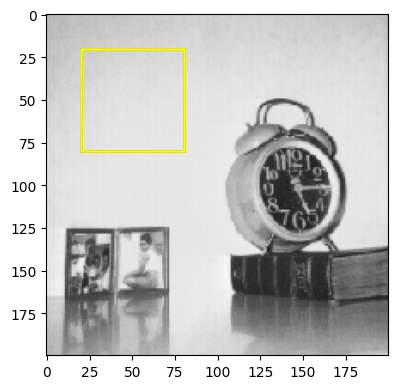

In [ ]:
draw(im, [[20, 20, 80, 80]])

Drawing random box by passing coordinates as a list along with label.

<AxesSubplot:>

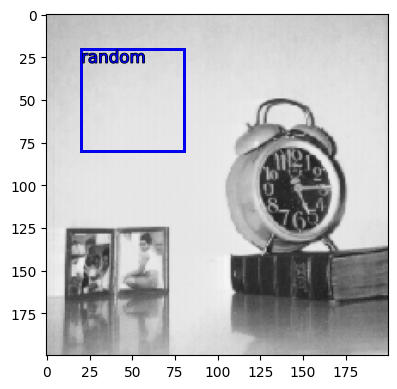

In [ ]:
draw(im, [[20, 20, 80, 80, 'random']], color={'random': 'blue'})

<AxesSubplot:>

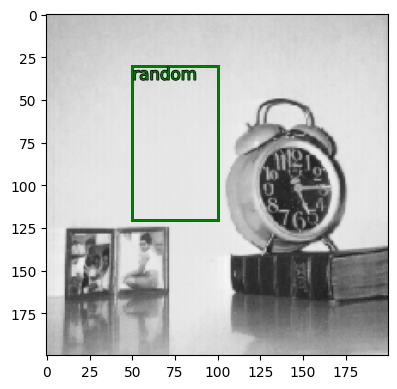

In [ ]:
draw(im, [{'x_min': 50, 'y_min': 30, 'x_max':100, 'y_max':120, 'label':'random'}], \
    color={'random': 'green'})

To display the calculated anchor boxes or any other type of bounding
boxes, `pybx` offers the `vis.VisBx` class.
First, `vis.VisBx` initializes all the params for the image
and loads its annotations (if available).
Upon calling the `show()` method on the instantiated 
`VisBx` object with our 
predicted annotations or anchor boxes, everything 
gets displayed.

In [ ]:
# | export
class VisBx:
    """VisBx is used to visualize the bounding boxes.
    The image on of which the bounding boxes are to be drawn can be instantiated with
    `VisBx()` if needed. Calling the `show()` method of the `VisBx()` instance accepts
    bounding box coordinates and labels that are to be shown.
    The boxes can be provided as any of the internal objects (`MultiBx`, `BaseBx`, ...)
    or as any other raw format accepted by the internal objects.

    Displaying image array and annotations object:
        This is the default approach used by VisBx(). If no arguments are passed, a tuple
        denoting the size for random noise `random_img_sz=(100, 100, 1)` is expected.
        Some arguments:
        :param image_arr: image array of shape `(H, W, C)`. If None, it is set to a
            random noise image of `image_sz=(100,100,3)` by default.
        :param annots: annotations is any accepted format (see above).

    Displaying from image and annotations file:
        To load and display the image, set `sample=True`.
        Some argmuments:
        :param ann_fn: annotations file name, default `annots.json`
        :param img_fn: image file name, default `image.jpg`
        :param load_ann: whether to load ann_fn or just the img_fn.
            If False, an empty annotations dict is returned: `dict(zip(voc_keys, [0, 0, 1, 1, '']))`
        :param pth: path to find `ann_fn` and `img_fn`, default `.`
        :param image_sz: size to resize the loaded image a different size (annotations scaled automatically)

    Common parameters:
        :param color: A dict of `color` can be passed to assign specific color to a
            specific `label` in the image: `color = {'frame': 'blue', 'clock': 'green'}`
        :param logits: Logits as `ndarray` that should be overlayed on top of the image
            or `bool` to generate random logits.
        :param feature_sz: Feature size to generate random logits if `logits` is not None.
    """

    def __init__(self, image_arr=None, image_sz=None, sample=False, **kwargs):
        if ("ann_fn" in kwargs) or ("img_fn" in kwargs) or sample:
            assert (
                image_sz is not None
            ), f"{inspect.stack()[0][3]} of {__name__}: Expected image_sz with sample=True"
            im, ann, lgt, clr = get_example(image_sz=image_sz, **kwargs)
        else:
            im, ann, lgt, clr = get_given_array(
                image_arr=image_arr, image_sz=image_sz, **kwargs
            )
        ann = get_bx(ann)
        store_attr("im, ann, lgt, clr")

    def show(self, coords=None, labels=None, color=None, ax=None, **kwargs):
        """Calling the `show()`Ananya method of the `VisBx()` instance accepts
        bounding box coordinates and labels that are to be shown.
        The boxes can be provided as any of the internal objects (`MultiBx`, `BaseBx`, ...)
        or as any other raw format accepted by the internal objects.
        """
        if color is not None:
            self.clr.update(color)
        if coords is None:
            coords = [[0, 0, 0, 0]]
        coords = get_bx(coords, labels)
        return draw(
            self.im, self.ann + coords, color=self.clr, logits=self.lgt, ax=ax, **kwargs
        )


### Display image array (default behaviour)

To display an image array (shape of `W, H, C`) directly, instead of 
loading from disk, pass an `ndarray`
to the `image_arr` argument. If available, also provide the
`annots` in any supported format. Displaying calculated anchors with a random image:

In [ ]:
anchor_boxes, anchor_labels = bx(image_sz, 3, 1)

<AxesSubplot:>

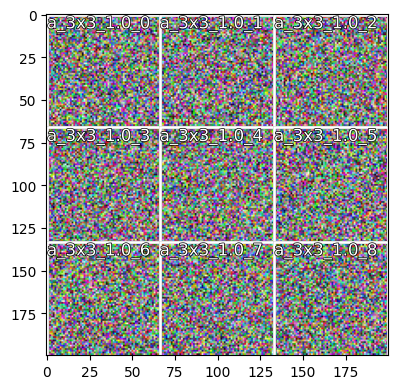

In [ ]:
v = VisBx(image_arr=np.random.random((*image_sz, 3)))  # a 200x200 image is used to overlay the anchor boxes in a 3x3 grid
v.show(anchor_boxes, anchor_labels)

<AxesSubplot:>

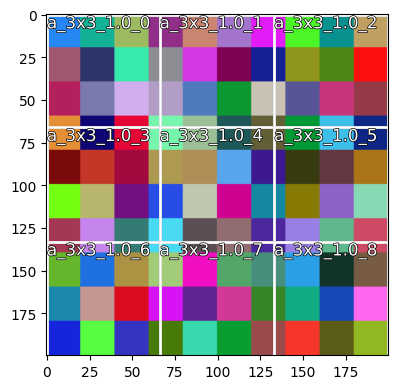

In [ ]:
v = VisBx(image_arr=np.random.random((10, 10, 3)), image_sz=(*image_sz, 3))  # a 10x10 random image will be resized to 200x200
v.show(anchor_boxes, anchor_labels)

### Load image and show annots

Displaying calculated anchors with a sample image. The original annotations are also rescaled to match the `image_sz`.

<AxesSubplot:>

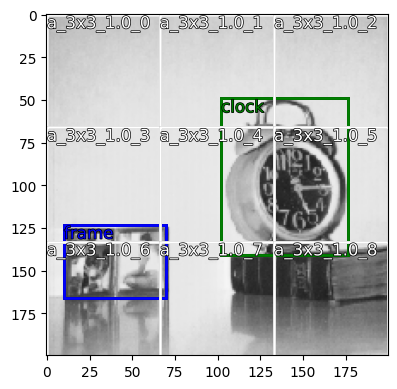

In [ ]:
v = VisBx(pth='../data/', img_fn='image.jpg', image_sz=image_sz)  # annots.json is being read from ../data/annots.json
v.show(anchor_boxes, anchor_labels)

### Customize colors

To customize the box colors, pass a dict `color` with the annotation name as key and color as value. In the example below an anchor box color is changed to red using its label `a_3x3_1.0_3` along with the annotations provided read from file.

<AxesSubplot:>

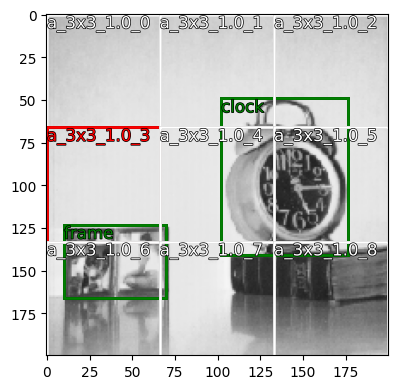

In [ ]:
v.show(anchor_boxes, anchor_labels, color={'a_3x3_1.0_3': 'red', 'frame': 'green', 'clock': 'green'})

In [ ]:
#|hide
from nbdev import nbdev_export
nbdev_export()